# Scaled EDA

In this notebook, our goal is to better analyze the temperature gap and negative temperature intervals at a VIN level.

In [1]:
import glob
import pandas as pd

In [2]:
files = glob.glob(r'C:\Users\achopra8\Documents\BDD Climate Control\Pivotted Data\*.csv') # read in all csvs
VINs = [file[file.index('Data') + 5:file.index('.')] for file in files]
data = []
for file in files:
    try:
        data.append(pd.read_csv(file).drop(['Unnamed: 0', 'epoch.1', 'epoch.2', 'epoch.3'], axis=1))
    except KeyError:
        data.append(pd.read_csv(file))

**Overview of VINs Being Studied:**

In [3]:
VIN_overview = pd.DataFrame({'VIN':VINs, 'Min Timestamp': [vin['cvdcus_timestamp_s_3'].astype('datetime64[ns]').min() for vin in data], 'Max Timestamp':[vin['cvdcus_timestamp_s_3'].astype('datetime64[ns]').max() for vin in data], '# Trips': [len(vin['trip'].unique()) for vin in data]})
VIN_overview['Avg. Trips/Day'] = VIN_overview['# Trips'] / (VIN_overview['Max Timestamp'] - VIN_overview['Min Timestamp']).map(lambda x: x.days)
#VIN_overview['VIN'] = VIN_overview['VIN'].map(lambda x: '************' + x[13:])
VIN_overview

,VIN,Min Timestamp,Max Timestamp,# Trips,Avg. Trips/Day
0,1FTEW1C53KFB01079,2019-05-01 14:40:10,2019-07-18 04:14:46,84,1.090909
1,1FTEW1E45KFA14370,2019-08-06 05:24:08,2019-08-22 02:35:04,60,4.000000
2,1FTEW1E46KFA53937,2019-08-06 15:43:32,2019-08-14 22:29:48,29,3.625000
3,1FTEW1E46KKC10745,2019-07-26 04:56:39,2019-08-15 03:48:01,54,2.842105
4,1FTEW1E48KFA09227,2019-05-01 19:16:06,2019-05-21 20:28:31,67,3.350000
5,1FTEW1E49KKC50608,2019-05-01 04:09:22,2019-05-08 20:07:40,21,3.000000
6,1FTEW1E54KFA50916,2019-08-07 00:15:51,2019-08-29 02:17:01,42,1.909091
7,1FTEW1EG4KFA57544,2019-05-01 00:16:05,2019-05-27 18:37:10,37,1.423077
8,1FTEW1EP1KFA04560,2019-05-04 16:25:05,2019-06-09 12:57:30,37,1.057143
9,1FTFW1E17KFA36784,2019-08-27 04:21:49,2019-08-29 17:01:28,7,3.500000


## Analyzing Temperature Gap

In [4]:
for i in range(len(data)):
    data[i]['temp_gap'] = data[i]['HvacEvap_Te_Actl'] - data[i]['HvacEvap_Te_Rq'] # add temp gap col
    data[i] = data[i][data[i]['HvacAirCond_B_Rq'] == 'Yes'].drop('HvacAirCond_B_Rq', axis=1).reset_index(drop=True) # ensure ac is on
    data[i]['epoch_diff'] = data[i]['epoch'].diff() # recalc diff in epoch

In [5]:
from scipy.stats import describe
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [6]:
@interact
def gap_dist(VIN = VINs):
    gaps = data[VINs.index(VIN)]['temp_gap']
    print(describe(gaps.dropna()))
    fig, ax = plt.subplots(figsize=(25, 10))
    sns.distplot(gaps, color='Purple')
    plt.title('Distribution of Temperature Gap (Actual - Requested)', fontsize=25)
    plt.xticks(fontsize=15)
    plt.xlabel('Temperature Gap (C)', fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Density', fontsize=15)

interactive(children=(Dropdown(description='VIN', options=('1FTEW1C53KFB01079', '1FTEW1E45KFA14370', '1FTEW1E4…

C:\Users\achopra8\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Use the colorbar set_ticks() method instead.
  if __name__ == '__main__':


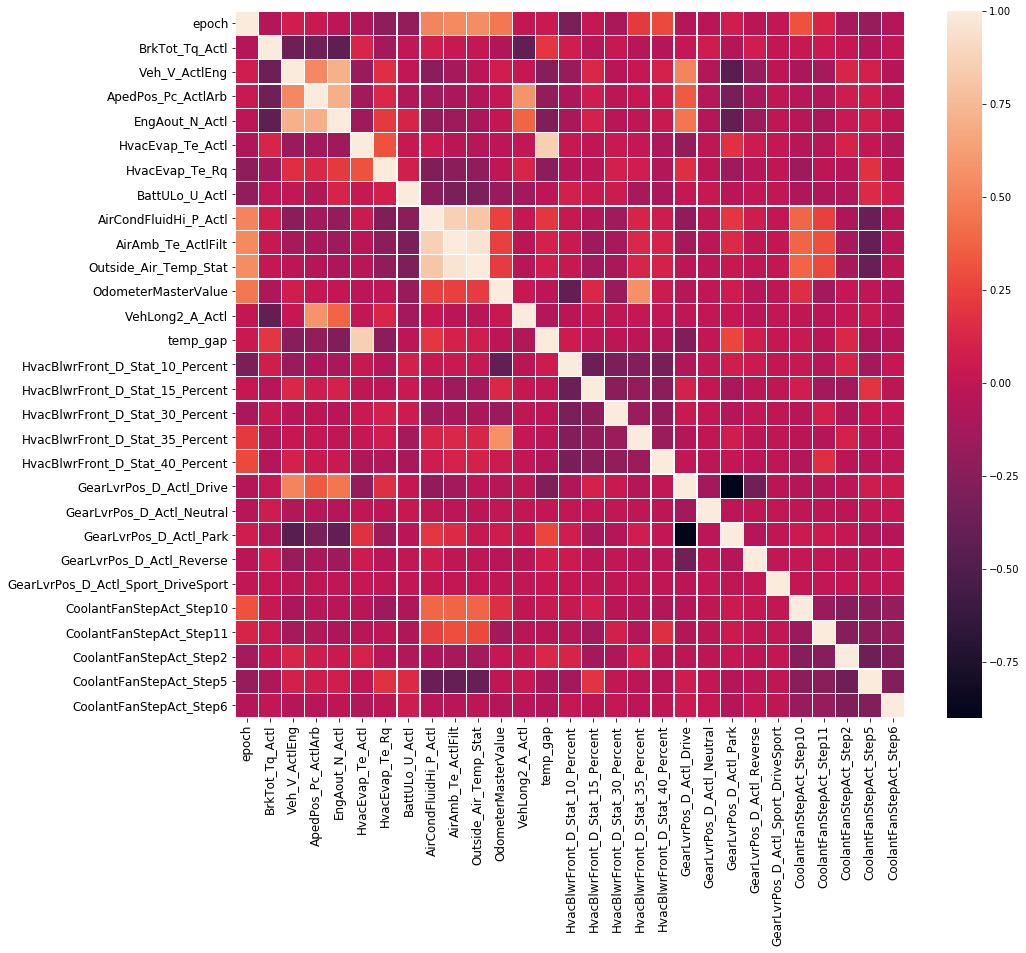

In [7]:
data_concat = pd.concat(data).drop(['cvdcus_timestamp_s_3', 'trip', 'epoch_diff'], axis=1) # don't need in corr mat
data_concat = data_concat[data_concat['CoolantFanStepAct'].isin(data_concat['CoolantFanStepAct'].value_counts().head(5).index)] # high val counts
data_concat = data_concat[data_concat['HvacBlwrFront_D_Stat'].isin(data_concat['HvacBlwrFront_D_Stat'].value_counts().head(5).index)] # high val counts
#data_concat = data_concat[data_concat['HvacAirCond_B_Rq'] == 'Yes']
f, ax = plt.subplots(figsize=(15, 13)) 
sns.heatmap(pd.get_dummies(data_concat).corr(), linewidths=0.25)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.figure.axes[-1].set_yticks(fontsize=20)

In [353]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()
# # function to get df with corr matrix for each trip
# def get_corr_mat_all_trips():
#     trip_data = []
#     temp_cols = ['temp_gap', 'HvacEvap_Te_Actl', 'HvacEvap_Te_Rq']
#     for vin in data:
#         for trip in vin['trip'].unique():
#             trip_data.append(pd.get_dummies(vin[vin['trip'] == trip][['epoch'] + list(vin.columns[4:])]).corr().loc[temp_cols].drop(temp_cols, axis=1))
#     return trip_data

# corr_data_all_trips = get_corr_mat_all_trips()
# corr_data_agg = pd.concat(corr_data_all_trips).reset_index().groupby('index').mean().reset_index()

# def make_barplot_agg_corr(x, y, title, xlab, ylab):
#     fig, ax = plt.subplots(figsize=(10, 18))
#     sns.barplot(x, y)
#     plt.title(title, fontsize=25)
#     plt.xticks(fontsize=15)
#     plt.xlabel(xlab, fontsize=15)
#     plt.yticks(fontsize=15)
#     plt.ylabel(ylab, fontsize=15)
#     plt.legend(prop={'size': 15})

# make_barplot_agg_corr(corr_data_agg.iloc[0, 1:],corr_data_agg.columns[1:], 'Correlation Coefficients for All Features vs. Temperature Gap', 'r', 'Feature')
# make_barplot_agg_corr(corr_data_agg.iloc[1, 1:],corr_data_agg.columns[1:], 'Correlation Coefficients for All Features vs. Actual Temperature', 'r', 'Feature')
# make_barplot_agg_corr(corr_data_agg.iloc[1, 1:],corr_data_agg.columns[1:], 'Correlation Coefficients for All Features vs. Requested Temperature', 'r', 'Feature')

Let's segment trips further and define an event as an interval where the speed changes from > 5 km/hr to < 5 km/hr. This will help narrow our focus only on events with abnormal gaps.

In [9]:
import numpy as np
# function to flag event by above definition
def flag_events(pivotted):
    # find index of start of event
    a = np.array(pivotted['speed < 5'])
    x = a[1:-1]
    event_start = (np.flatnonzero((a[2:] == x) & (x != a[:-2]))+1).tolist()
    
    # add flags to segment events
    event_flag = 1
    for i in ([0] + event_start):
        pivotted.loc[i, 'event'] = event_flag
        event_flag += 1
    pivotted['event'] = pivotted['event'].fillna(method='ffill')
    pivotted['event'] = pivotted['event'].astype(int)

for i in range(len(data)):
    data[i]['speed < 5'] = data[i]['Veh_V_ActlEng'].map(lambda x: 1 if x < 5 else 0)
    data[i]['event'] = float('nan')
    flag_events(data[i])
    data[i].drop('speed < 5', axis=1, inplace=True)
    cols = list(data[i].columns[:4]) + [data[i].columns[-1]] + list(data[i].columns[4:-1])
    data[i] = data[i][cols]

# merge events lasting < 10 sec
# for i in range(len(data)):
#     events = data[i].groupby('event')['epoch'].agg(lambda x: x.max() - x.min())
#     events = events[events < 10].index
#     for event in events:
#         if event == 1:
#             data[i]['event'] = data[i]['event'].replace({event: event + 1})
#         else:
#             data[i]['event'] = data[i]['event'].replace({event: event - 1})
#     data[i]['event'] = data[i]['event'].replace({event: i + 1 for i, event in enumerate(data[i]['event'].unique())}) # reset event flags

Next, we will only keep events such that 
1. they are within a trip
2. the average temperature gap > 5°C
3. the duration > 30 seconds

In [74]:
events_interest = [vin[vin['event'] == event].assign(VIN=VINs[i]) for i, vin in enumerate(data) for event in vin['event'].unique() if vin[vin['event'] == event]['temp_gap'].mean() > 5 and (vin[vin['event'] == event]['epoch'].max() - vin[vin['event'] == event]['epoch'].min()) > 30 and vin[vin['event'] == event]['trip'].unique().shape[0] == 1]
data_concat = pd.concat([vin.assign(VIN=VINs[i]) for i, vin in enumerate(data)]) # all data

Let's categorize events based on the following labels:
1. **Park** (gear position in park)
2. **Start/Stop** (gear position not park; engine 0 <= rpm < 500 and speed < 2 km/hr)
3. **Idle** (gear position not park; engine 500 <= rpm < 1000; speed < 2 km/hr)
4. **Other**

In [77]:
events_interest = pd.concat(events_interest).drop(['cvdcus_timestamp_s_3', 'epoch_diff'], axis=1).groupby(['VIN', 'trip', 'event']).agg(lambda x: pd.Series.mode(x) if x.dtype == 'object' else (x.max() - x.min() if x.name == 'epoch'else x.mean())).reset_index().rename({'epoch': 'duration'}, axis=1)
events_interest = events_interest[list(events_interest.columns[0:3]) + [events_interest.columns[-1]] + list(events_interest.columns[3:-1])]

def classify_event(row):
    try:
        if row['GearLvrPos_D_Actl'] == 'Park':
            return 'Park'
        elif row['Veh_V_ActlEng'] < 2 and 0 <= row['EngAout_N_Actl'] < 500:
            return 'Start/Stop'
        elif 500 <= row['EngAout_N_Actl'] < 1000 and row['Veh_V_ActlEng'] < 2:
            return 'Idle'
        else:
            return 'Other'
    except ValueError:
        if row['Veh_V_ActlEng'] < 2 and 0 <= row['EngAout_N_Actl'] < 500:
            return 'Start/Stop'
        elif 500 <= row['EngAout_N_Actl'] < 1000 and row['Veh_V_ActlEng'] < 2:
            return 'Idle'
        else:
            return 'Other'

events_interest['label'] = events_interest.apply(classify_event, axis=1)

for col in ['HvacBlwrFront_D_Stat', 'GearLvrPos_D_Actl', 'CoolantFanStepAct']: # make all cols str
    events_interest[col] = events_interest[col].astype(str)

Text(0.5, 1.0, 'Proportion of Events in Each Category (Total = 493)')

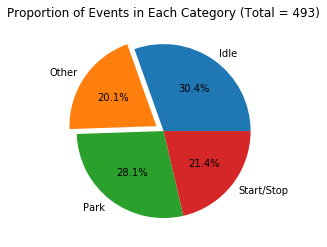

In [703]:
fig, ax = plt.subplots()
plt.pie(events_interest.groupby('label')['event'].nunique(), labels=events_interest.groupby('label')['event'].nunique().index, autopct='%1.1f%%', explode=(0, 0.1, 0, 0))
plt.title(f'Proportion of Events in Each Category (Total = {events_interest.shape[0]})')

Events falling into the "Other" category seem like the most concerning, as the underlying reason for the large temperature gaps for these events is not clear. Presented below is a comparison of statistics between events labeled "Other", filtered events, and all events.

In [178]:
other_stats = events_interest[events_interest['label'] == 'Other'].drop(['OdometerMasterValue'], axis=1).describe(include='all')
all_events_stats = events_interest.drop(['OdometerMasterValue'], axis=1).describe(include='all')
global_stats = data_concat.drop(['OdometerMasterValue'], axis=1).describe(include='all')
stats_comparison = pd.concat([other_stats, all_events_stats, global_stats]).drop(['trip', 'event', 'VIN', 'label', 'epoch', 'epoch_diff', 'cvdcus_timestamp_s_3'], axis=1).loc[['count', 'mean', 'top']]
stats_comparison = stats_comparison.iloc[3:]
stats_comparison = stats_comparison[['duration'] + ['temp_gap'] + list(stats_comparison.columns[2:])]
stats_comparison.index = ['"Other" Events Avg.', 'All Events Avg.', 'Global Avg.', '"Other" Events Mode', 'All Events Mode', 'Global Mode']
stats_comparison.transpose()

,"""Other"" Events Avg.",All Events Avg.,Global Avg.,"""Other"" Events Mode",All Events Mode,Global Mode
duration,176.051,567.694,NaN,NaN,NaN,NaN
temp_gap,7.26437,7.96755,0.824577,NaN,NaN,NaN
BrkTot_Tq_Actl,324.156,1033.26,273,NaN,NaN,NaN
Veh_V_ActlEng,27.0528,5.83765,44.7191,NaN,NaN,NaN
ApedPos_Pc_ActlArb,6.50541,1.7,7.23347,NaN,NaN,NaN
EngAout_N_Actl,1239.22,696.179,1180.31,NaN,NaN,NaN
HvacEvap_Te_Actl,9.43416,10.2429,3.79587,NaN,NaN,NaN
HvacEvap_Te_Rq,2.16979,2.27532,2.97129,NaN,NaN,NaN
BattULo_U_Actl,13.8552,13.4721,13.4983,NaN,NaN,NaN
AirCondFluidHi_P_Actl,12.7072,11.8384,9.21066,NaN,NaN,NaN


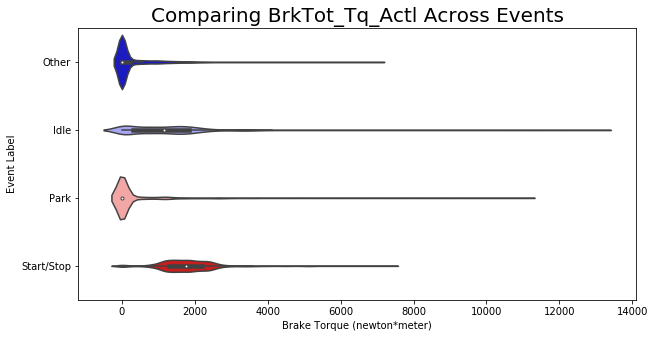

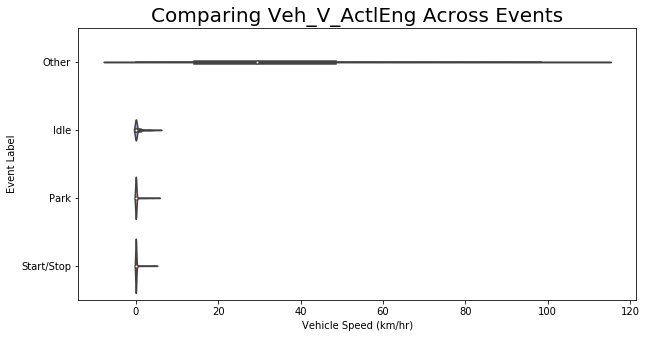

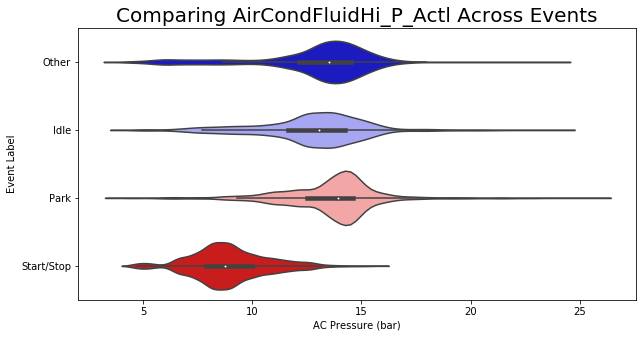

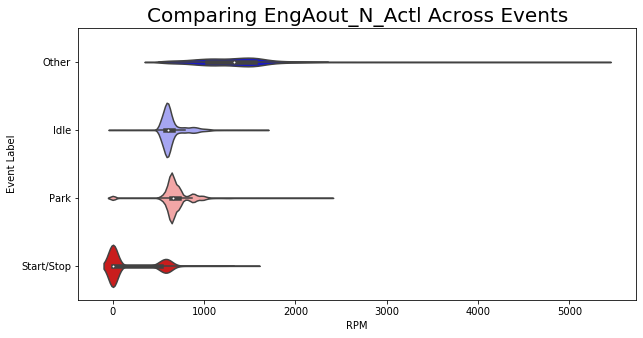

In [243]:
def violin(data, feature, unit):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.violinplot(y='label', x=feature, data=d, palette='seismic')
    plt.title(f'Comparing {feature} Across Events', fontsize=20)
    plt.xticks(fontsize=10)
    plt.ylabel('Event Label', fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel(unit, fontsize=10)
    
for feature, unit in zip(['BrkTot_Tq_Actl', 'Veh_V_ActlEng', 'AirCondFluidHi_P_Actl', 'EngAout_N_Actl'], ['Brake Torque (newton*meter)', 'Vehicle Speed (km/hr)', 'AC Pressure (bar)', 'RPM']):
    violin(d, feature, unit)

In [634]:
from matplotlib.lines import Line2D
import matplotlib as mpl
# function to plot gap between actual and requested temp.
def plot_vs_time_event(df, VIN, trip_num, feature, temp_features_to_append, xlab='Time Elapsed (s)'):
    plt.close('all')
    if data[0][feature].dtype == 'O':
        df['epoch'] = (df['epoch'] - df['epoch'].min()).astype(int)
        fig, ax = plt.subplots(3, 1, figsize=(28, 22))
        ax[0].set_xlabel(xlab, fontsize=20)
        ax[1].set_xlabel(xlab, fontsize=20)
        ax[2].set_xlabel(xlab, fontsize=20)
        ax[0].tick_params(axis='both', which='major', labelsize=20)
        ax[1].tick_params(axis='both', which='major', labelsize=20)
        ax[2].tick_params(axis='both', which='major', labelsize=20)
        df['epoch'] = (df['epoch'] - df['epoch'].min()).astype(int)
        sns.lineplot(x='epoch', y='temp_gap', hue=feature, data=df, ax=ax[0], marker='o', markersize=10)
        ax[0].set_ylabel('Gap (C)', fontsize=20)
        ax[0].legend(prop={'size': 20})
        sns.lineplot(x='epoch', y='HvacEvap_Te_Actl', hue=feature, data=df, ax=ax[1], marker='o', markersize=10)
        ax[1].set_ylabel('Actual (C)', fontsize=20)
        ax[1].legend(prop={'size': 20})
        sns.lineplot(x='epoch', y='HvacEvap_Te_Rq', hue=feature, data=df, ax=ax[2], marker='o', markersize=10)
        ax[2].set_ylabel('Requested (C)', fontsize=20)
        ax[2].legend(prop={'size': 20})
        ax[0].set_title(f'Temperature vs. Time (VIN {VIN}; Trip {trip_num})', fontsize=30)
        return fig
    
    else:
        fig, ax1 = plt.subplots(figsize=(38, 15))
        plt.title(f'Features vs. Time (VIN {VIN}; Trip {trip_num})', fontsize=30)
        plt.xticks(fontsize=20)
        ax2 = ax1.twinx()
        df['epoch'] = (df['epoch'] - df['epoch'].min()).astype(int)
        df_for_vis = pd.melt(df, id_vars=['epoch'], value_vars=temp_features_to_append, var_name='Feature', value_name='temp')
        df_for_vis['time_elap'] = (df_for_vis['epoch'] - df_for_vis['epoch'].min()).astype(int)
        sns.lineplot(x="time_elap", y="temp", hue="Feature", data=df_for_vis, ax=ax1, marker='o', markersize=10, legend=False, palette={'HvacEvap_Te_Actl':'blue', 'temp_gap':'green', 'HvacEvap_Te_Rq':'orange'}) 
        sns.lineplot(x='epoch', y=feature, data=df, ax=ax2, marker='o', markersize=10, color='purple')
        ax1.set_ylabel('Temperature (C)', fontsize=20)
        ax1.tick_params(axis='y', which='major', labelsize=20)
        ax2.set_ylabel(feature, fontsize=20)
        ax2.tick_params(axis='y', which='major', labelsize=20)
        ax1.set_xlabel(xlab, fontsize=20)
        custom_lines = [Line2D([0], [0], lw=4, color='Blue'),
                    Line2D([0], [0], lw=4, color='orange'),
                    Line2D([0], [0], lw=4, color='green'), Line2D([0], [0], lw=4, color='Purple')]
        plt.legend(custom_lines, ['Actual', 'Requested', 'Gap', f'{feature}'], prop={'size': 20})
        return fig

In [641]:
save_fig_w=widgets.Checkbox(value=False, description='Save Plot')
event_label_w = events_interest['label'].unique()
VIN_w = widgets.Dropdown()
event_num_w=widgets.Dropdown()
feature_w=[col for col in data[0].columns[5:] if col not in ['HvacEvap_Te_Actl', 'HvacEvap_Te_Rq', 'temp_gap', 'HvacAirCond_B_Rq']]
actl_w=widgets.Checkbox(value=False, description='Include Actual Temperature')
rq_w=widgets.Checkbox(value=False, description='Include Requested Temperature')
gap_w=widgets.Checkbox(value=True, description='Include Gap')

@interact
def show_rel(save_fig=widgets.Checkbox(value=False, description='Save Plot'), event_label=event_label_w, VIN=VIN_w, event_num=event_num_w, feature=feature_w, actl=actl_w, rq=rq_w, gap=gap_w):
    VIN_w.options = events_interest[events_interest['label'] == event_label]['VIN'].unique()
    event_num_w.options = sorted(events_interest[(events_interest['label'] == event_label) & (events_interest['VIN'] == VIN)]['event'])
    temp_features_to_plot = []
    if actl:
        temp_features_to_plot.append('HvacEvap_Te_Actl')
    if rq:
        temp_features_to_plot.append('HvacEvap_Te_Rq')
    if gap:
        temp_features_to_plot.append('temp_gap')
    event = data_concat[(data_concat['event'] == event_num) & (data_concat['VIN'] == VIN)]
    try:
        trip_num = event['trip'].iloc[0]
    except Exception:
        plt.close()
    try:
        fig = plot_vs_time_event(event, VIN, trip_num, feature, temp_features_to_plot)
        if save_fig:
            try:
                fig.savefig(f'temp_gaps/VIN{VIN}_Event{event_num}_{feature}.png')
            except FileNotFoundError:
                print("Directory doesn't exists! Make directory called 'temp_gaps'")
    except ValueError:
        print('Feature not present in trip!')
        plt.close()

interactive(children=(Checkbox(value=False, description='Save Plot'), Dropdown(description='event_label', opti…

In [33]:
from matplotlib.lines import Line2D
import matplotlib as mpl
# function to plot gap between actual and requested temp.
def plot_vs_time(df, trip_num, feature, temp_features_to_append, xlab='Time Elapsed (s)', title='Trip'):
    plt.close('all')
    if data[0][feature].dtype == 'O':
        df['epoch'] = (df['epoch'] - df['epoch'].min()).astype(int)
        fig, ax = plt.subplots(3, 1, figsize=(28, 22))
        ax[0].set_xlabel(xlab, fontsize=20)
        ax[1].set_xlabel(xlab, fontsize=20)
        ax[2].set_xlabel(xlab, fontsize=20)
        ax[0].tick_params(axis='both', which='major', labelsize=20)
        ax[1].tick_params(axis='both', which='major', labelsize=20)
        ax[2].tick_params(axis='both', which='major', labelsize=20)
        df['epoch'] = (df['epoch'] - df['epoch'].min()).astype(int)
        sns.lineplot(x='epoch', y='temp_gap', hue=feature, data=df, ax=ax[0], marker='o', markersize=10)
        ax[0].set_ylabel('Gap (C)', fontsize=20)
        ax[0].legend(prop={'size': 20})
        sns.lineplot(x='epoch', y='HvacEvap_Te_Actl', hue=feature, data=df, ax=ax[1], marker='o', markersize=10)
        ax[1].set_ylabel('Actual (C)', fontsize=20)
        ax[1].legend(prop={'size': 20})
        sns.lineplot(x='epoch', y='HvacEvap_Te_Rq', hue=feature, data=df, ax=ax[2], marker='o', markersize=10)
        ax[2].set_ylabel('Requested (C)', fontsize=20)
        ax[2].legend(prop={'size': 20})
        ax[0].set_title(f'Temperature vs. Time ({title} {trip_num})', fontsize=30)
        return fig
    
    else:
        fig, ax1 = plt.subplots(figsize=(38, 15))
        plt.title(f'Features vs. Time ({title} {trip_num})', fontsize=30)
        plt.xticks(fontsize=20)
        ax2 = ax1.twinx()
        df['epoch'] = (df['epoch'] - df['epoch'].min()).astype(int)
        df_for_vis = pd.melt(df, id_vars=['epoch'], value_vars=temp_features_to_append, var_name='Feature', value_name='temp')
        df_for_vis['time_elap'] = (df_for_vis['epoch'] - df_for_vis['epoch'].min()).astype(int)
        sns.lineplot(x="time_elap", y="temp", hue="Feature", data=df_for_vis, ax=ax1, marker='o', markersize=10, legend=False, palette={'HvacEvap_Te_Actl':'blue', 'temp_gap':'green', 'HvacEvap_Te_Rq':'orange'}) 
        sns.lineplot(x='epoch', y=feature, data=df, ax=ax2, marker='o', markersize=10, color='purple')
        ax1.set_ylabel('Temperature (C)', fontsize=20)
        ax1.tick_params(axis='y', which='major', labelsize=20)
        ax2.set_ylabel(feature, fontsize=20)
        ax2.tick_params(axis='y', which='major', labelsize=20)
        ax1.set_xlabel(xlab, fontsize=20)
        custom_lines = [Line2D([0], [0], lw=4, color='Blue'),
                    Line2D([0], [0], lw=4, color='orange'),
                    Line2D([0], [0], lw=4, color='green'), Line2D([0], [0], lw=4, color='Purple')]
        plt.legend(custom_lines, ['Actual', 'Requested', 'Gap', f'{feature}'], prop={'size': 20})
        return fig

In [34]:
save_fig_w=widgets.Checkbox(value=False, description='Save Plot')
VINs_w=VINs
trip_num_w=widgets.Dropdown()
feature_w=[col for col in data[0].columns[4:] if col not in ['HvacEvap_Te_Actl', 'HvacEvap_Te_Rq', 'temp_gap', 'HvacAirCond_B_Rq']]
actl_w=widgets.Checkbox(value=False, description='Include Actual Temperature')
rq_w=widgets.Checkbox(value=False, description='Include Requested Temperature')
gap_w=widgets.Checkbox(value=True, description='Include Gap')

@interact
def show_rel(save_fig=save_fig_w, VIN=VINs_w, trip_num=trip_num_w, feature=feature_w, actl=actl_w, rq=rq_w, gap=gap_w):
    trip_num_w.options = data[VINs.index(VIN)]['trip'].unique()
    temp_features_to_plot = []
    if actl:
        temp_features_to_plot.append('HvacEvap_Te_Actl')
    if rq:
        temp_features_to_plot.append('HvacEvap_Te_Rq')
    if gap:
        temp_features_to_plot.append('temp_gap')
    df = data[VINs.index(VIN)]
    
    trip = df[(df['trip'] == trip_num)]
    trip = trip[['epoch'] + list(trip.columns[4:])]
    try:
        fig = plot_vs_time(trip, trip_num, feature, temp_features_to_plot)
        if save_fig:
            try:
                fig.savefig(f'temp_gaps/VIN{VIN}_Trip{trip_num}_{feature}.png')
            except FileNotFoundError:
                print("Directory doesn't exists! Make directory called 'temp_gaps'")
    except ValueError:
        print('Feature not present in trip!')
        plt.close()

interactive(children=(Checkbox(value=False, description='Save Plot'), Dropdown(description='VIN', options=('1F…

## Analyzing Negative Temperature Intervals

In [244]:
def map_temp_to_sign_get_intervals(pivotted, upper_bound_temp):
    pivotted['HvacEvap_Te_Actl_sign'] = pivotted['HvacEvap_Te_Actl'].map(lambda x: -1 if 0 <= x <= upper_bound_temp else np.sign(x)) # col to keep track of sign

    neg_temp_intervals = []
    for trip in pivotted['trip'].unique():
        temp = pivotted[pivotted['trip'] == trip]
        for i, g in temp.groupby([(pivotted['HvacEvap_Te_Actl_sign'] != pivotted['HvacEvap_Te_Actl_sign'].shift()).cumsum()]):
            if g.loc[g.index[0], 'HvacEvap_Te_Actl_sign'] == -1:
                neg_temp_intervals.append(g)
    #neg_temp_intervals.sort(key=lambda x: x['epoch'].max() - x['epoch'].min())
    return neg_temp_intervals

neg_temp_intervals_imputed_2d = [map_temp_to_sign_get_intervals(vin, 0) for vin in data]
for i in range(len(neg_temp_intervals_imputed_2d)):
    for interval in neg_temp_intervals_imputed_2d[i]:
        interval['VIN'] = VINs[i]

neg_temp_intervals_imputed = [interval for vin in neg_temp_intervals_imputed_2d for interval in vin]

In [273]:
neg_temp_interval_freq = pd.DataFrame({'VIN': ['*************' + vin[13:] for vin in VINs], '# Intervals': [[interval['VIN'].unique()[0] for interval in neg_temp_intervals_imputed].count(vin) for vin in VINs]})
neg_temp_interval_freq['Freq/Day'] = neg_temp_interval_freq['# Intervals'] / (VIN_overview['Max Timestamp'] - VIN_overview['Min Timestamp']).map(lambda x: x.days)
neg_temp_interval_freq

,VIN,# Intervals,Freq/Day
0,*************1079,40,0.519481
1,*************4370,26,1.733333
2,*************3937,9,1.125000
3,*************0745,27,1.421053
4,*************9227,24,1.200000
5,*************0608,1,0.142857
6,*************0916,5,0.227273
7,*************7544,3,0.115385
8,*************4560,4,0.114286
9,*************6784,0,0.000000


DescribeResult(nobs=158, minmax=(0.0, 28.0), mean=4.1835443037974684, variance=15.462912198661613, skewness=2.9601766662319258, kurtosis=13.245217244554954)


Text(0, 0.5, 'Density')

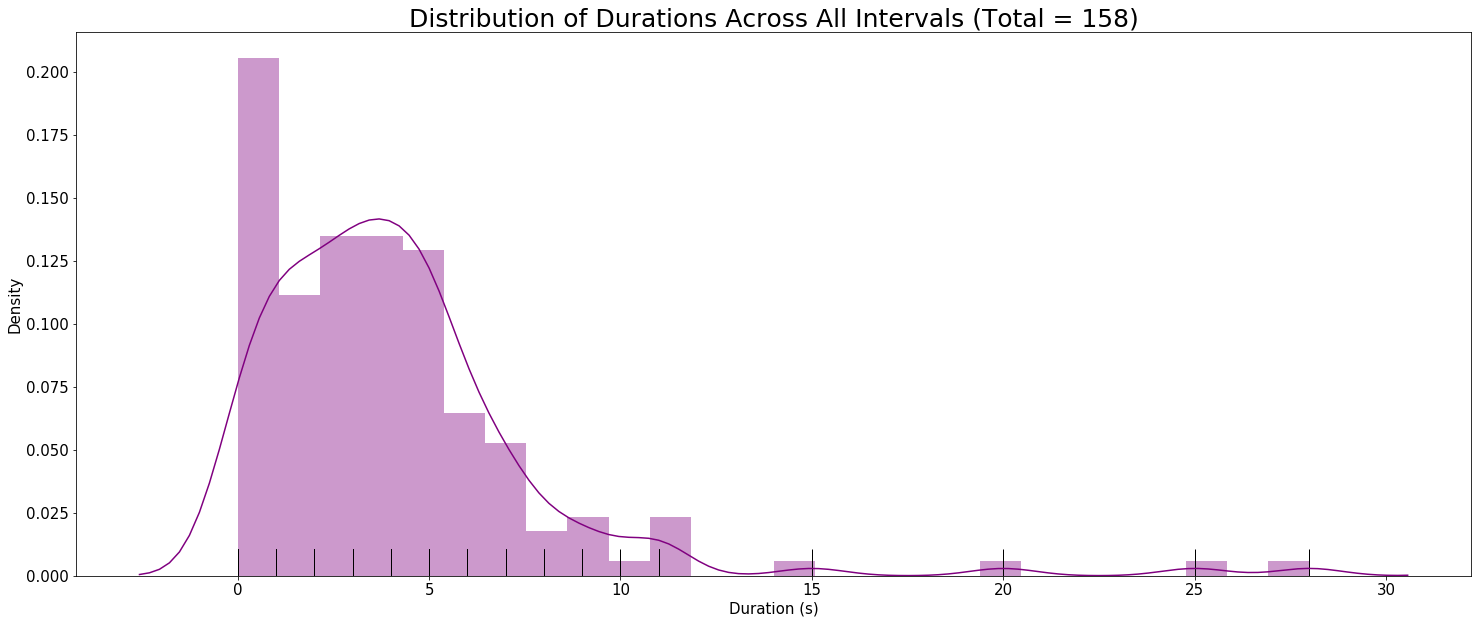

In [12]:
time_elap_imputed = [interval['epoch'].max() - interval['epoch'].min() for interval in neg_temp_intervals_imputed]
print(describe(time_elap_imputed))
fig, ax = plt.subplots(figsize=(25, 10))
sns.distplot(time_elap_imputed, color='Purple', rug=True, rug_kws={"color": "black"})
plt.title(f'Distribution of Durations Across All Intervals (Total = {len(neg_temp_intervals_imputed)})', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Duration (s)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density', fontsize=15)

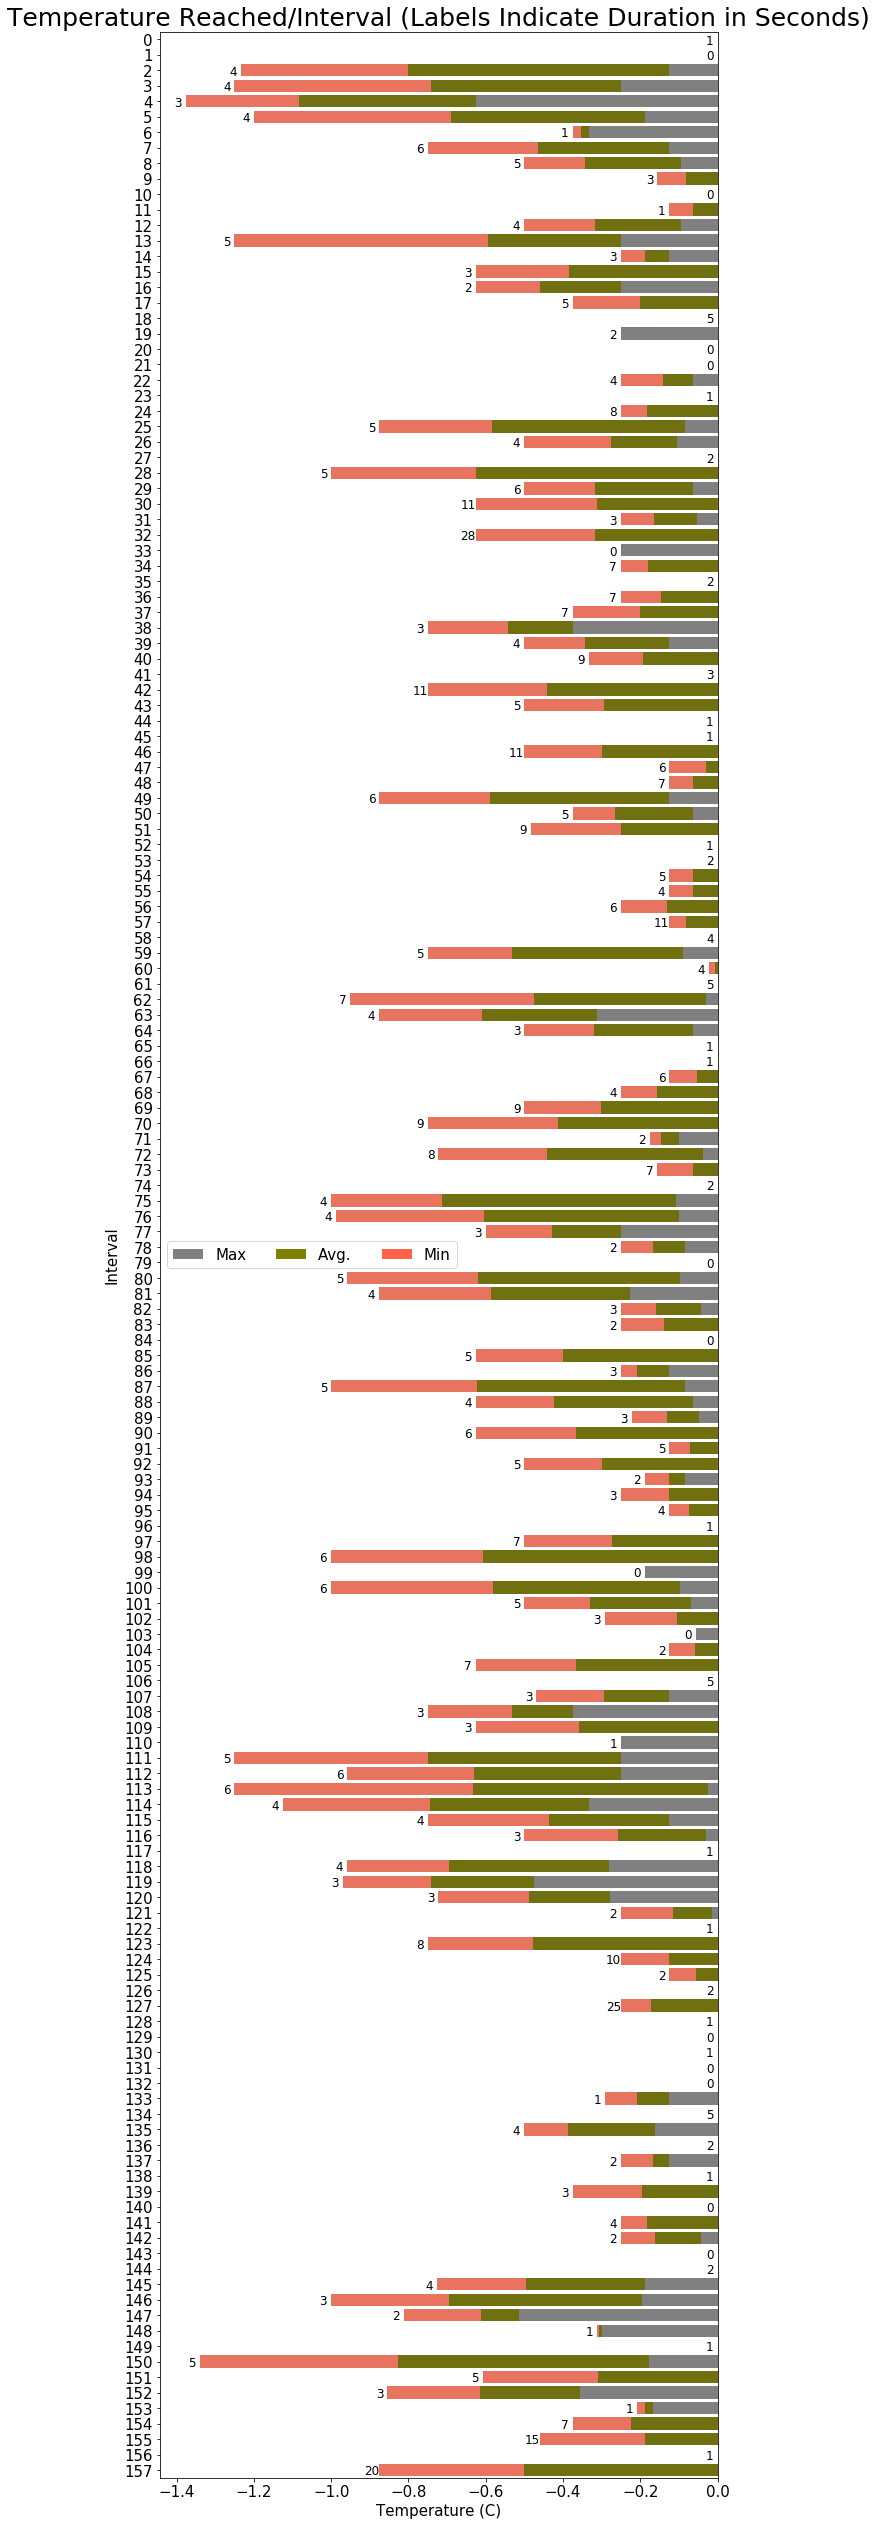

In [266]:
fig, ax = plt.subplots(figsize=(10, 45))
min_temps = [interval['HvacEvap_Te_Actl'].min() for interval in neg_temp_intervals_imputed]
avg_temps = [interval['HvacEvap_Te_Actl'].mean() for interval in neg_temp_intervals_imputed]
max_temps = [interval['HvacEvap_Te_Actl'].max() for interval in neg_temp_intervals_imputed]
sns.barplot(y=[str(i) for i in range(len(neg_temp_intervals_imputed))], x=min_temps, order=[str(i) for i in range(len(neg_temp_intervals_imputed))], color='tomato', orient='h')
sns.barplot(y=[str(i) for i in range(len(neg_temp_intervals_imputed))], x=avg_temps, order=[str(i) for i in range(len(neg_temp_intervals_imputed))], color='olive', orient='h')
g = sns.barplot(y=[str(i) for i in range(len(neg_temp_intervals_imputed))], x=max_temps, order=[str(i) for i in range(len(neg_temp_intervals_imputed))], color='grey', orient='h')
plt.title('Temperature Reached/Interval (Labels Indicate Duration in Seconds)', fontsize=25)
plt.yticks(fontsize=15)
plt.ylabel('Interval', fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Temperature (C)', fontsize=15)
leg_colors = [plt.Rectangle((0,0),1,1,fc='grey'), plt.Rectangle((0,0),1,1,fc='olive'), plt.Rectangle((0,0),1,1,fc="tomato")]
plt.legend(leg_colors, ['Max', 'Avg.', 'Min'], ncol = 3, prop={'size':15})

for interval, temp, duration in zip(range(len(neg_temp_intervals_imputed)), min_temps, time_elap_imputed):
    g.text(temp - 0.02, interval + 0.3, round(duration), color='black', ha="center", fontsize=12)

Text(0, 0.5, 'Temperature (C)')

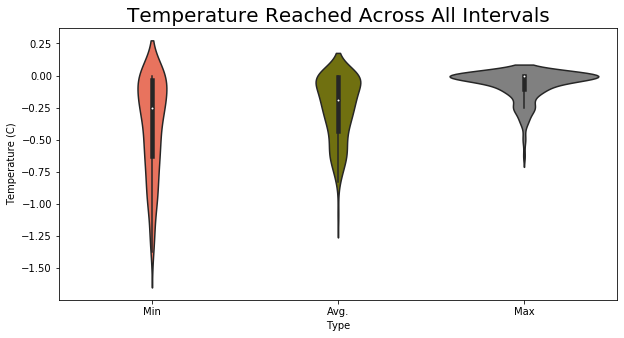

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
pal = {'Min':'tomato', 'Avg.':'olive', 'Max':'grey'}
sns.violinplot(x='variable', y='value', data=pd.melt(pd.DataFrame({'Min':min_temps, 'Avg.':avg_temps, 'Max':max_temps})), palette=pal)
plt.title('Temperature Reached Across All Intervals', fontsize=20)
plt.xticks(fontsize=10)
plt.xlabel('Type', fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Temperature (C)', fontsize=10)

In [38]:
def plot_gap(df, title, xlab, ylab, s=None):  
    fig, ax = plt.subplots(figsize=(25, 10))
    sns.lineplot(x=(df['epoch'] - df['epoch'].min()).astype(int), y=df['HvacEvap_Te_Actl'], marker='o', markersize=10)
    plt.title(title, fontsize=25)
    plt.xticks(fontsize=15)
    plt.xlabel(xlab, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel(ylab, fontsize=15)

@interact
def show_gap(interval=list(range(len(neg_temp_intervals_imputed)))):
    plot_gap(neg_temp_intervals_imputed[interval], f'Interval {interval}', 'Time Elapsed (s)', 'Actual Temperature (C)')

interactive(children=(Dropdown(description='interval', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

DescribeResult(nobs=158, minmax=(8.0, 1925427.0), mean=139125.45569620252, variance=112554863077.1923, skewness=3.750517903294961, kurtosis=14.539580634524668)


Text(0, 0.5, 'Density')

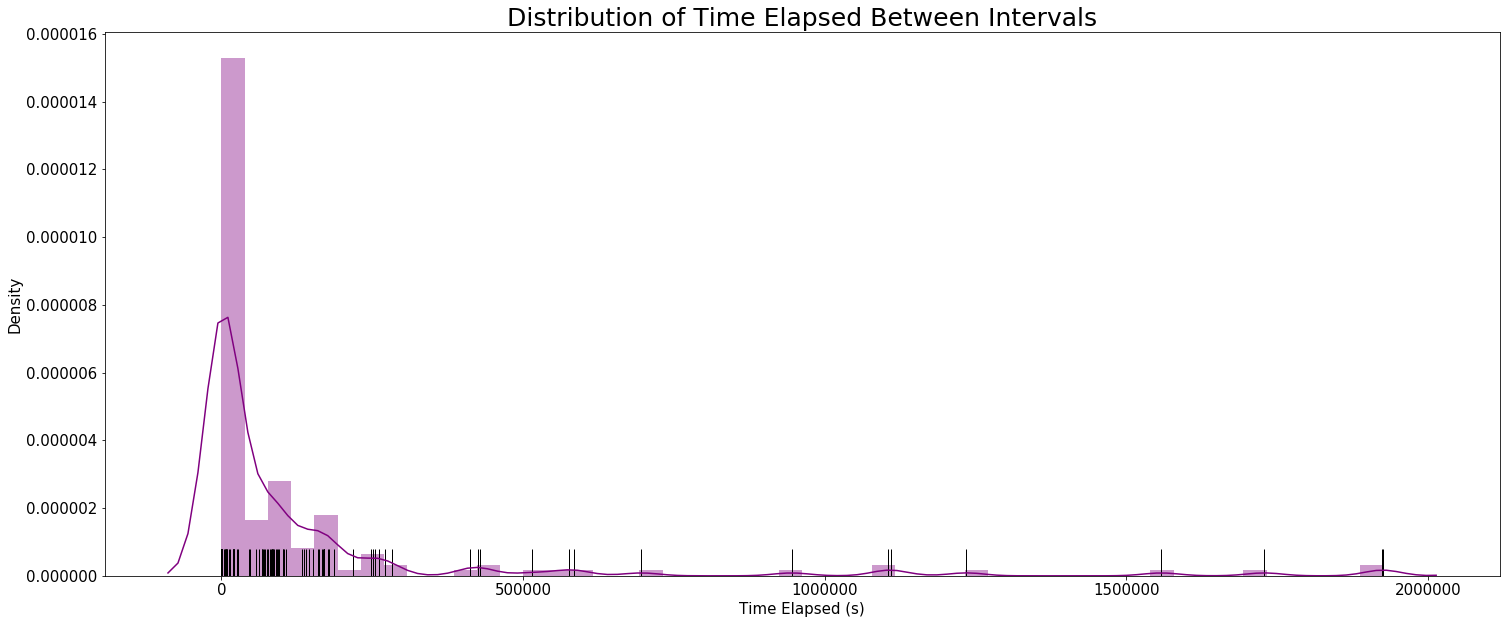

In [265]:
time_elap_between_intervals = [np.diff(sorted([data[i]['epoch'].min()] + [interval['epoch'].iloc[0] for interval in neg_temp_intervals_imputed_2d[i]])) for i in range(len(neg_temp_intervals_imputed_2d))]
time_elap_between_intervals = [time for vin in time_elap_between_intervals for time in vin]

print(describe(time_elap_between_intervals))
fig, ax = plt.subplots(figsize=(25, 10))
sns.distplot(time_elap_between_intervals, color='Purple', rug=True, rug_kws={"color": "black"})
plt.title('Distribution of Time Elapsed Between Intervals', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Time Elapsed (s)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density', fontsize=15)

In [17]:
@interact
def generate_heatmap(save_fig=widgets.Checkbox(value=False, description='Save Plot'), interval=range(len(neg_temp_intervals_imputed))):
    interval = neg_temp_intervals_imputed[interval]
    f, ax = plt.subplots(figsize=(14, 12)) 
    try:
        heatmap = sns.heatmap(pd.get_dummies(interval[['epoch'] + list(interval.columns[4:-1])]).corr(), annot=True, linewidths=0.5, ax=ax)
        if save_fig:
            try:
                f.savefig('neg_temp_intervals/heatmaps/VIN{}_Trip{}.png'.format(interval['VIN'].iloc[0], interval['trip'].iloc[0]), dpi=300, bbox_inches='tight')
            except FileNotFoundError:
                print("Directory doesn't exists! Make directory called 'neg_temp_intervals/heatmaps'")
        return heatmap
    except ValueError:
        print('Cannot produce heatmap since interval only lasts for 1 second!')
        plt.close()
        

interactive(children=(Checkbox(value=False, description='Save Plot'), Dropdown(description='interval', options…

**Descriptive Statistics of Negative Temperature Intervals:**

In [43]:
pd.concat(neg_temp_intervals_imputed).describe().drop(['epoch', 'epoch_diff', 'trip', 'event', 'HvacEvap_Te_Actl_sign'], axis=1).drop('count').transpose().style.background_gradient(cmap='Blues', subset='std')

,mean,std,min,25%,50%,75%,max
BrkTot_Tq_Actl,249.439022,530.453162,0.000000,0.000000,0.000000,4.944444,2434.666667
Veh_V_ActlEng,41.775073,27.698241,0.000000,18.824091,41.978462,65.470000,100.505000
ApedPos_Pc_ActlArb,8.561330,10.874019,0.000000,0.000000,6.495833,13.694828,100.000000
EngAout_N_Actl,1264.379044,439.477310,525.750000,1029.385382,1257.673469,1431.179673,4051.000000
HvacEvap_Te_Actl,-0.301164,0.298146,-1.375000,-0.500000,-0.250000,-0.034375,0.000000
HvacEvap_Te_Rq,2.189949,0.867408,1.666667,2.000000,2.000000,2.000000,6.500000
BattULo_U_Actl,13.571067,0.485205,12.500000,13.256250,13.562500,13.687500,14.687500
AirCondFluidHi_P_Actl,11.102065,1.506241,5.000000,10.187500,11.250000,12.062500,15.062500
AirAmb_Te_ActlFilt,33.591720,4.834353,5.000000,30.750000,33.500000,37.250000,43.000000
Outside_Air_Temp_Stat,31.945068,4.637633,4.000000,29.000000,32.500000,35.500000,40.000000
